# Capstone Study Region - Colorado

## Author: Jacquelyn Witte

### This notebook outlines the primary study region and data highlights using the NASA Global Landslide Catalog (GLC)

In [1]:
import os

import earthpy as et
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from geopandas import GeoDataFrame
from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

sns.set(font_scale=1.2, style="whitegrid")

### Read the GLC CSV into a pandas dataFrame

In [2]:
glc_file = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data', 'capstone', 'landslide', 
                        'nasa_global_landslide_catalog_point.csv')
print(os.path.exists(glc_file))

# Read the file
glc = pd.read_csv(glc_file)

# Extract Colorado data
glc_co = glc[(glc['country_code'] == 'US') 
             & (glc['admin_division_name'] == 'Colorado') 
             & (glc['landslide_trigger'] != 'freeze_thaw') 
             & (glc['landslide_trigger'] != 'snowfall_snowmelt') 
             & (glc['landslide_trigger'] != 'earthquake') 
             & (glc['landslide_trigger'] != 'leaking_pipe') 
             & (glc['landslide_trigger'] != 'no_apparent_trigger') 
             & (glc['landslide_trigger'] != 'other')              
             & (glc['landslide_trigger'] != 'unknown')
            ]

# covert to datetime
glc_co['date'] = pd.to_datetime(glc_co['event_date'])
glc_co = glc_co.set_index('date').sort_index()

# Print the shape
print(glc_co.shape)

# Check that everylandslide has a location
print(glc_co['latitude'].isna().any())
print(glc_co['longitude'].isna().any())

True
(129, 31)
False
False


#### Isolate data > year 2015 

In [3]:
glc_co_gt2015 = glc_co[glc_co.index > '2015-01-01']
glc_co_gt2015.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39 entries, 2015-04-27 00:00:00 to 2020-07-27 12:00:00
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   OBJECTID                 39 non-null     int64  
 1   Shape                    39 non-null     object 
 2   source_name              39 non-null     object 
 3   source_link              39 non-null     object 
 4   event_id                 39 non-null     int64  
 5   event_date               39 non-null     object 
 6   event_time               24 non-null     object 
 7   event_title              39 non-null     object 
 8   event_description        39 non-null     object 
 9   location_description     39 non-null     object 
 10  location_accuracy        39 non-null     object 
 11  landslide_category       39 non-null     object 
 12  landslide_trigger        39 non-null     object 
 13  landslide_size           39 non-null     obj

### Histogram of Landslide size

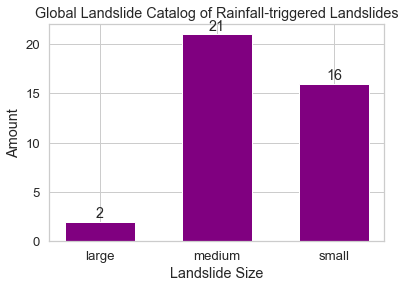

In [4]:
stack_plot = []
labels = []
for i, data in glc_co_gt2015.groupby('landslide_size'):
    labels.append(i)
    stack_plot.append(data['landslide_size'].count())

labels, stack_plot

f, ax = plt.subplots()
width = 0.6
bars = ax.bar(labels, stack_plot, width, color='purple')
ax.set(xlabel='Landslide Size',
       ylabel='Amount',
       title='Global Landslide Catalog of Rainfall-triggered Landslides')

ax.bar_label(bars, padding=1);

### Histogram of Landslide cause

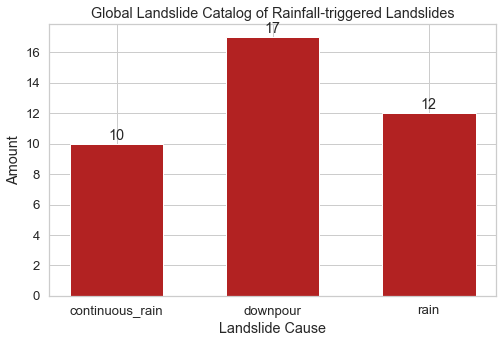

In [5]:
stack_plot = []
labels = []
for i, data in glc_co_gt2015.groupby('landslide_trigger'):
    labels.append(i)
    stack_plot.append(data['landslide_trigger'].count())

labels, stack_plot

f, ax = plt.subplots(figsize=(8,5))
width = 0.6
bars = ax.bar(labels, stack_plot, width, color='firebrick')
ax.set(xlabel='Landslide Cause',
       ylabel='Amount',
       title='Global Landslide Catalog of Rainfall-triggered Landslides')

ax.bar_label(bars, padding=1);

### Histogram of Landslide category

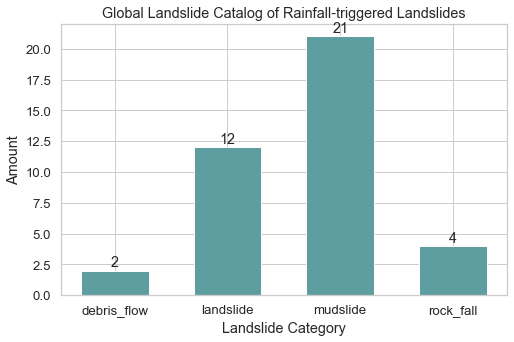

In [6]:
stack_plot = []
labels = []
for i, data in glc_co_gt2015.groupby('landslide_category'):
    labels.append(i)
    stack_plot.append(data['landslide_category'].count())

labels, stack_plot

f, ax = plt.subplots(figsize=(8,5))
width = 0.6
bars = ax.bar(labels, stack_plot, width, color='cadetblue')
ax.set(xlabel='Landslide Category',
       ylabel='Amount',
       title='Global Landslide Catalog of Rainfall-triggered Landslides')

ax.bar_label(bars, padding=1);

### Map the 2015-2020 landslides over Colorado

In [7]:
geometry = [Point(xy) for xy in zip(
    glc_co_gt2015['longitude'], glc_co_gt2015['latitude'])]
crs = 'epsg:4326'
glc_co_epsg4326 = GeoDataFrame(glc_co_gt2015, crs=crs, geometry=geometry)
glc_co_epsg4326.index.min(), glc_co_epsg4326.index.max()

(Timestamp('2015-04-27 00:00:00'), Timestamp('2020-07-27 12:00:00'))

In [8]:
# Create a symbology dictionary that maps "trigger" to color. 
triggers = np.unique(glc_co_epsg4326['landslide_trigger'])
colors = ['red', 'green', 'blue', 'orange','lightgray']
points_symb = dict(zip(triggers,colors))
points_symb

{'continuous_rain': 'red', 'downpour': 'green', 'rain': 'blue'}

In [9]:
m2 = folium.Map([39.0, -105.27], zoom_start=6, tiles='Stamen Terrain')

for i, loc in glc_co_epsg4326.iterrows():
    # print(i, loc['latitude'], loc['longitude'])
    folium.Marker(location=[loc['latitude'], loc['longitude']],
                  icon=folium.Icon(color=points_symb[loc['landslide_trigger']],
                                   prefix='glyphicon', icon='off')).add_to(m2)

# Continuous Rain
folium.CircleMarker(location=[40.5, -103], radius=10,
                    color='red',
                    fill_color='red',
                    fill_opacity=1.0).add_to(m2)
folium.Marker(
    location=[40.5, -102.7],
    icon=folium.DivIcon(
        html=f"""<b>{'Continuous Rain'}</b>""")
).add_to(m2)

# Downpour
folium.CircleMarker(location=[40, -103], radius=10,
                    color='green',
                    fill_color='green',
                    fill_opacity=1.0).add_to(m2)
folium.Marker(
    location=[40, -102.7],
    icon=folium.DivIcon(
        html=f"""<b>{'Downpour'}</b>""")
).add_to(m2)

# Rain
folium.CircleMarker(location=[39.5, -103], radius=10,
                    color='dodgerblue',
                    fill_color='dodgerblue',
                    fill_opacity=1.0).add_to(m2)
folium.Marker(
    location=[39.5, -102.7],
    icon=folium.DivIcon(
        html=f"""<b>{'Rain'}</b>""")
).add_to(m2)

       
#Add Title
loc = 'Rainfall-triggered landslides in Colorado (2015-2020)'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc) 

m2.get_root().html.add_child(folium.Element(title_html))

m2

In [10]:
# Export map to an html
map_output = os.path.join(et.io.HOME,
                           'earth-analytics',
                           'capstone-landslides-soilmoisture', 'plots',
                           'map_landslides_sites.html')
m2.save(map_output)